# U-net type encoder-decoder convolutional neural network

## Create a U-net type encoder-decoder CNN in Keras

### Import required Python libraries



In [139]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
import napari
import skimage as sk
import skimage.segmentation
from skimage.io import imread, imsave

import h5py   # HDF5 data file management library
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.python.keras.layers import concatenate, UpSampling2D, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

from glob import glob
from tqdm.notebook import tqdm

### Define helper functions

In [2]:
def image_stack_blur(image_stack, sigma_x, sigma_y):
    
    import cv2
    
    image_size = image_stack.shape[1] * image_stack.shape[2]
    img = []
    
    for i in range(len(image_stack)):
        
        img.append(cv2.GaussianBlur(image_stack[i], ksize=(0,0), sigmaX=sigma_x, sigmaY=sigma_y))
    
    img = np.array(img)
    img = img.reshape(len(img), image_size, 1)
    
    return(img)

### Import, process, and shape the dataset

In [4]:
data_path = 'Y:/Model/'  # nb: begin with /
labels = ['input_data1', 'input_data2', 'output_data']

#Inputs
#Mito
input_data_filename1 = data_path + 'Mito.h5' 
input_data1 = np.array(h5py.File(input_data_filename1, 'r').get('Mito'))
input_data1 = input_data1.reshape((*input_data1.shape, 1))
print(labels[0]+':', input_data1.shape)

#Drp1
input_data_filename2 = data_path + 'Drp1.h5' 
input_data2 = np.array(h5py.File(input_data_filename2, 'r').get('Drp1'))
input_data2 = input_data2.reshape((*input_data2.shape, 1))
print(labels[1]+':', input_data1.shape)

#Concatenate channels
input_data = np.concatenate((input_data1, input_data2), axis=3)
input_data= input_data.reshape((*input_data.shape, 1))
print('Inputs:', input_data.shape)

#Outputs
output_data_filename = data_path + 'Proc.h5'
output_data = np.array(h5py.File(output_data_filename, 'r').get('Proc'))
output_data = output_data.reshape((*output_data.shape, 1, 1))
print('Outputs:', output_data.shape)

input_data1: (37000, 128, 128, 1)
input_data2: (37000, 128, 128, 1)
Inputs: (37000, 128, 128, 2, 1)
Outputs: (37000, 128, 128, 1, 1)


In [8]:
blending = 'additive'
opacity = 0.7

cmap_mito = 'gray'
cmap_drp1 = 'green'

cmap_output = 'red'
gamma_output = 0.2

viewer = napari.Viewer()
viewer.add_image(input_data1.reshape(input_data1.shape[:-1]), colormap=cmap_mito, 
                 blending=blending, opacity=opacity, name='Mito')
viewer.add_image(input_data2.reshape(input_data2.shape[:-1]), colormap=cmap_drp1, 
                 blending=blending, opacity=opacity, name='Drp1')
viewer.add_image(output_data.reshape(output_data.shape[:-2]), colormap=cmap_output, 
                 blending=blending, gamma=gamma_output, name='Output')

<Image layer 'Output' at 0x20ea4b53d00>

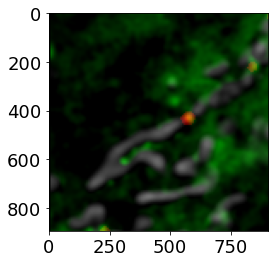

In [150]:
plt.imshow(imread('rotation/input_data1_t500.png'))

In [148]:
ymin, ymax, xmin, xmax = (20, 917, 367, 1264)

img_rotation = [imread(filename)[ymin:ymax, xmin:xmax] for filename in glob('rotation/*')]

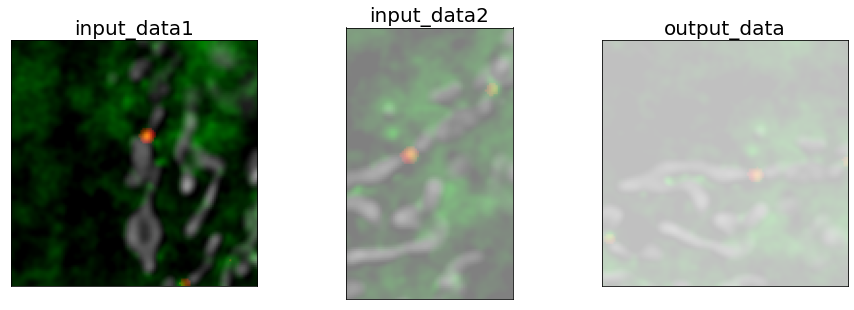

In [149]:
item_id = 3600
cmap = ['gray', 'Greens', 'inferno']
alpha = [1, 0.5, 0.25]

fig, axes = plt.subplots(1, 3, figsize=(5*3, 5))
for ax, img, label, c, a in zip(axes, img_rotation, labels, cmap, alpha):
  ax.imshow(img, cmap=c, alpha=a)
  ax.set_title(label, size=20)
  ax.set(xticks=[], yticks=[])

plt.show()

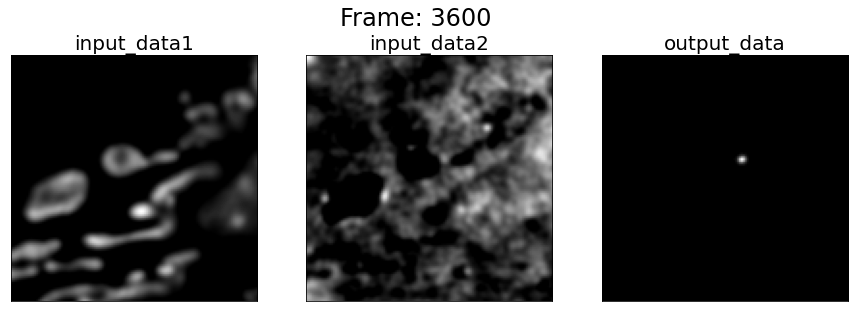

In [55]:
item_id = [50, 500, 800]
cmap = 'gray'

fig, axes = plt.subplots(1, 3, figsize=(5*3, 5))
for ax, i in zip(axes, item_id):
  ax.imshow(data[i].reshape(data.shape[1:3]), cmap=cmap)
  ax.set_title('input_data1', size=20)
  ax.set(xticks=[], yticks=[])

plt.show()

## Split train and test

In [56]:
# Split data set into [test] and [train+valid] subsets using sklearn train_test_split function

data_set_test_trainvalid_ratio = 0.2
data_split_state = None   # integer (usually 42) or None for random split on each call
input_train, input_test, output_train, output_test =  train_test_split(input_data, 
                                                                       output_data, 
                                                                       test_size=data_set_test_trainvalid_ratio, 
                                                                       random_state=data_split_state)

print('test:[train+valid] split ratio : ', data_set_test_trainvalid_ratio)
print('data_split_state : ', data_split_state)
print()

print('input_data : ', input_data.shape, input_data.dtype)
print('input_train : ', input_train.shape, input_train.dtype)
print('input_test : ', input_test.shape, input_test.dtype)
print()
print('output_data : ', output_data.shape, output_data.dtype)
print('output_train : ', output_train.shape, output_train.dtype)
print('output_test : ', output_test.shape, output_test.dtype)

test:[train+valid] split ratio :  0.2
data_split_state :  None

input_data :  (37000, 128, 128, 2, 1) uint8
input_train :  (29600, 128, 128, 2, 1) uint8
input_test :  (7400, 128, 128, 2, 1) uint8

output_data :  (37000, 128, 128, 1, 1) uint8
output_train :  (29600, 128, 128, 1, 1) uint8
output_test :  (7400, 128, 128, 1, 1) uint8


### Define the network hyperparameters

In [58]:
optimizer_type = Adam(learning_rate=0.5e-3)  # optimisation algorithm: Adam 
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 20  # maxmimum number of epochs to be iterated
batch_size = 256   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

nb_filters = 8
firstConvSize = 9

### Define the network architecture

* using the Keras' *functional* model


In [59]:
input_shape = (128, 128, 2,1)
inputs = Input(shape=input_shape)

# encoder section

down0 = Conv3D(nb_filters, (firstConvSize, firstConvSize, 2), padding='same')(inputs)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0 = Conv3D(nb_filters, (firstConvSize, firstConvSize, 2), padding='same')(down0)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down0)
down0_pool = Reshape((64, 64, nb_filters))(down0_pool)
down0 = Reshape((128,128,nb_filters*2))(down0)
    
down1 = Conv2D(nb_filters*2, (3, 3), padding='same')(down0_pool)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(nb_filters*2, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    
# center section
    
center = Conv2D(nb_filters*4, (3, 3), padding='same')(down1_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(nb_filters*4, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
    
# decoder section with skip connections to the encoder section

up1 = UpSampling2D((2, 2))(center)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(nb_filters*2, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(nb_filters*2, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)

up0 = UpSampling2D((2, 2))(up1)
up0 = concatenate([down0, up0], axis=3)
up0 = Conv2D(nb_filters, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(nb_filters, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)

outputs = Conv2D(1, (1, 1), activation='relu')(up0)

### Compile the network

In [1]:
print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()


* Compiling the network model *



NameError: name 'Model' is not defined

### Train the neural network with the training dataset

In [ ]:
print('* Training the compiled network *')
print()

history = model.fit(input_train, output_train, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Epoch 1/20


### Plot the training history of the network

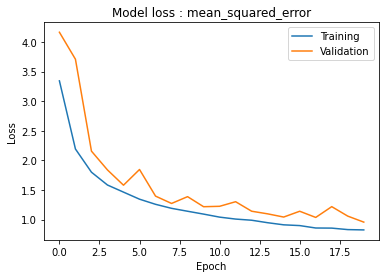

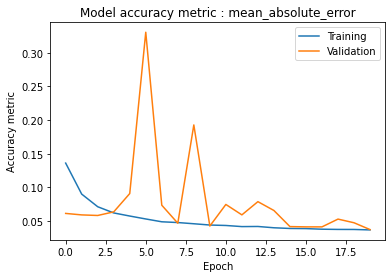

Average validation loss:  1.0815091729164124
Average training loss:  0.8529171228408814
Average validation accuracy:  0.0441882461309433
Average training accuracy:  0.03783506378531456


In [ ]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

AverageLossVal=history.history['val_loss']
AverageLossVal=sum(AverageLossVal[-5:])/len(AverageLossVal[-5:])

AverageLossTrain=history.history['loss']
AverageLossTrain=sum(AverageLossTrain[-5:])/len(AverageLossTrain[-5:])

AverageAccTrain=history.history[metrics[0]]
AverageAccTrain=sum(AverageAccTrain[-5:])/len(AverageAccTrain[-5:])

AverageAccVal=history.history['val_' + metrics[0]]
AverageAccVal=sum(AverageAccVal[-5:])/len(AverageAccVal[-5:])

print('Average validation loss: ', AverageLossVal)
print('Average training loss: ', AverageLossTrain)
print('Average validation accuracy: ', AverageAccVal)
print('Average training accuracy: ', AverageAccTrain)



### Evaluate the trained network performance on the unseen test dataset

In [ ]:
print('* Evaluating the performance of the trained network on the unseen test dataset *')
print()

evaluate_model = model.evaluate(x=input_test, y=output_test)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the unseen test dataset *

232/232 [==============================] - 14s 59ms/step - loss: 0.9543 - mean_absolute_error: 0.0379

Accuracy - mean_absolute_error: 0.038
Loss - mean_squared_error: 0.954


### Predict the output of a given input

* Predicting the output of a given input from test set *

test_id :  0



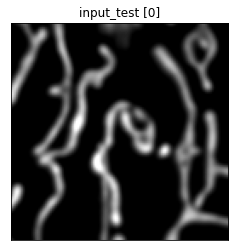

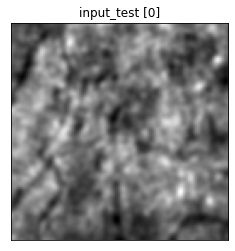

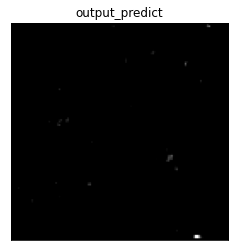

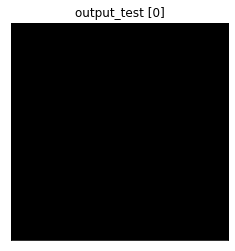

test_id :  1



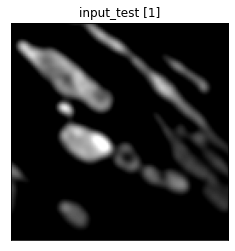

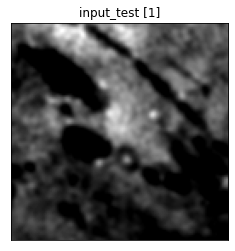

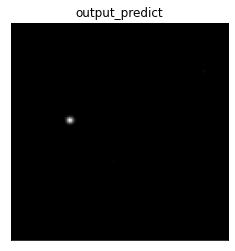

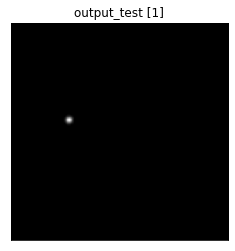

test_id :  2



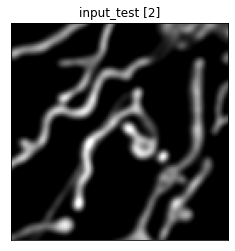

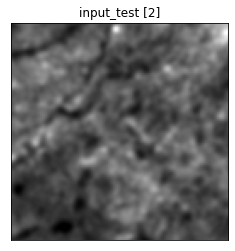

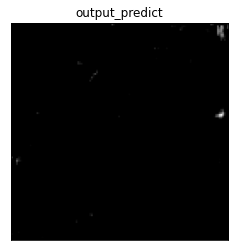

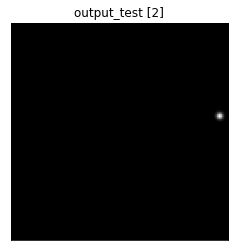

test_id :  3



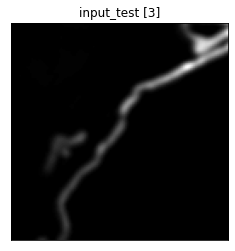

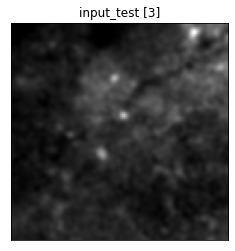

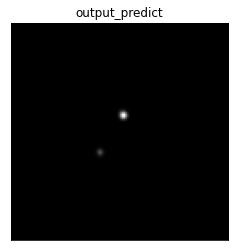

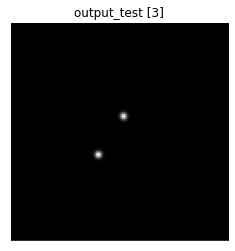

test_id :  4



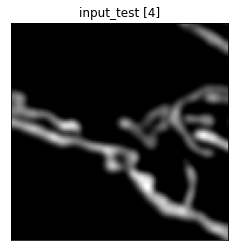

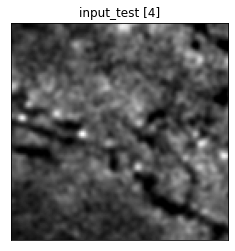

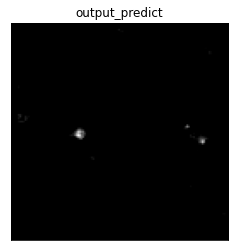

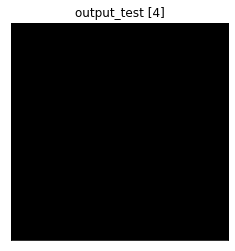

test_id :  5



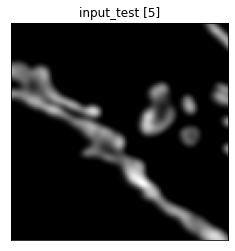

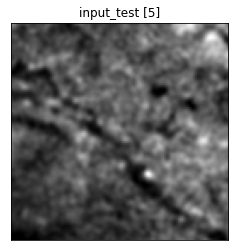

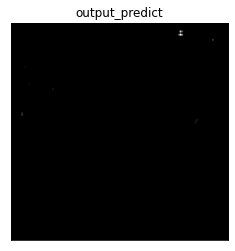

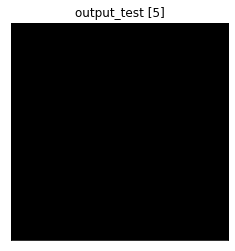

test_id :  6



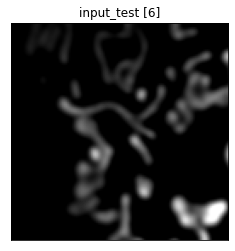

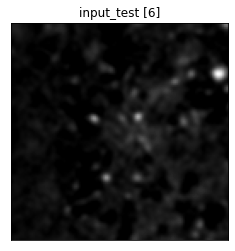

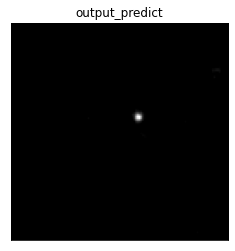

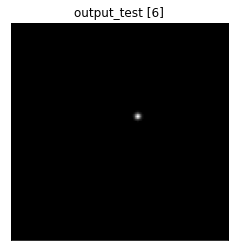

test_id :  7



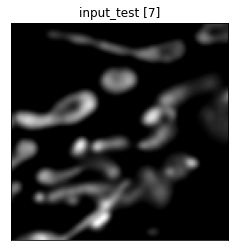

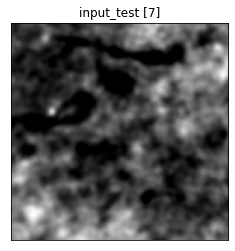

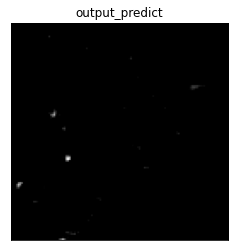

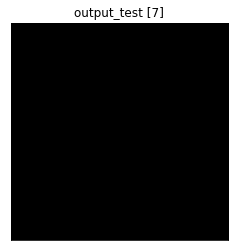

test_id :  8



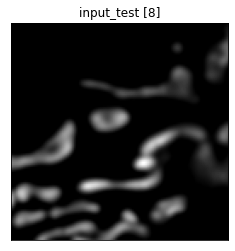

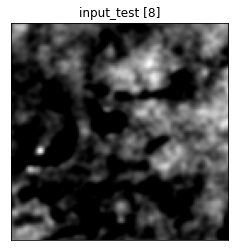

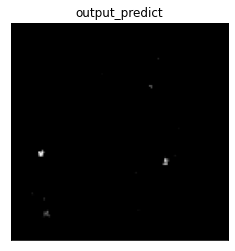

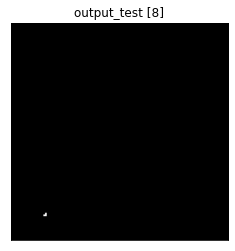

test_id :  9



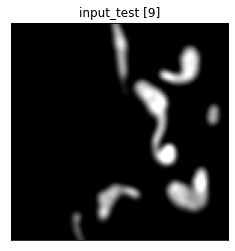

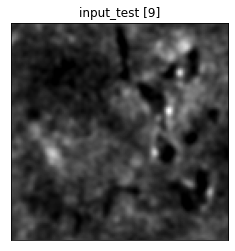

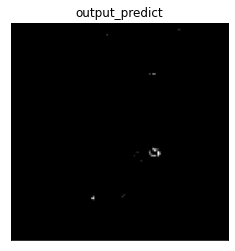

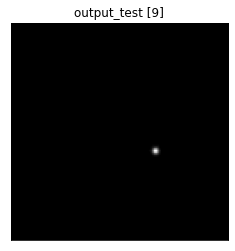

test_id :  10



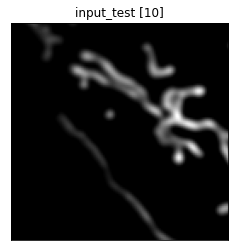

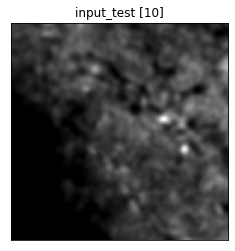

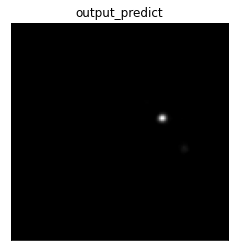

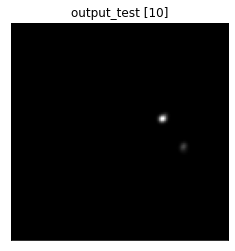

test_id :  11



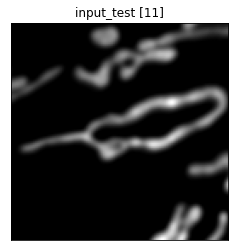

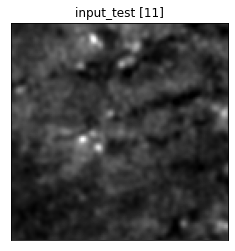

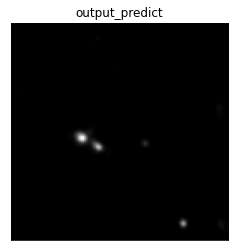

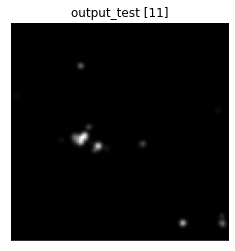

test_id :  12



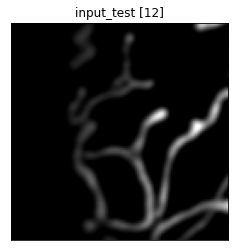

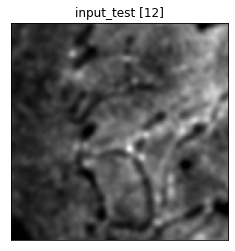

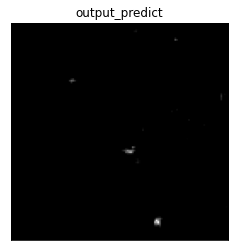

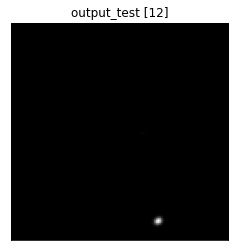

test_id :  13



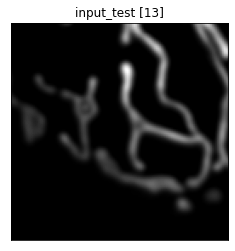

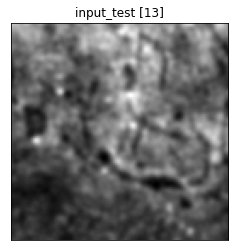

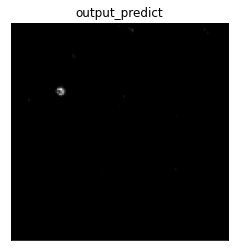

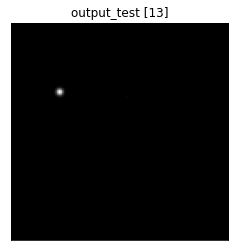

test_id :  14



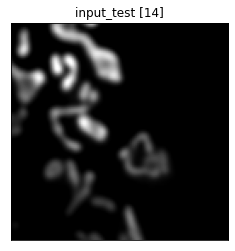

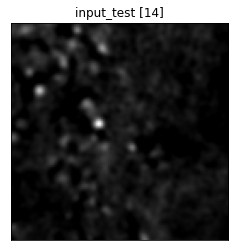

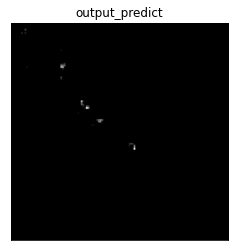

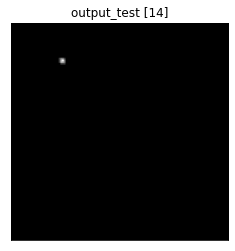

test_id :  15



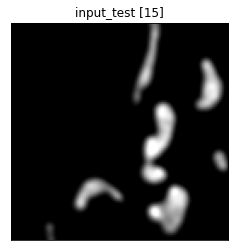

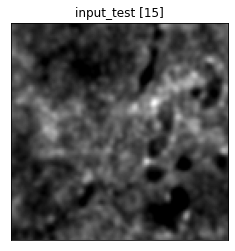

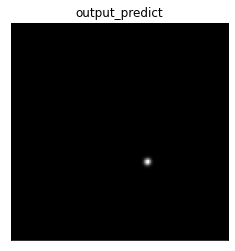

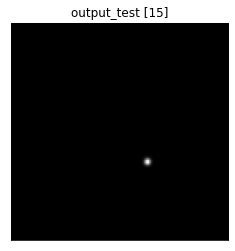

test_id :  16



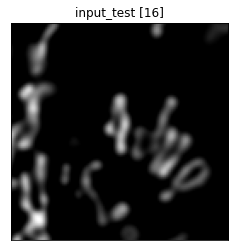

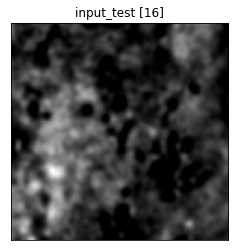

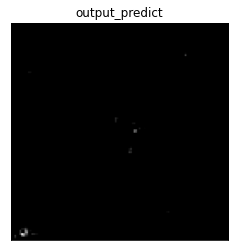

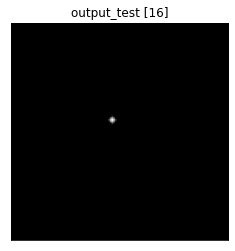

test_id :  17



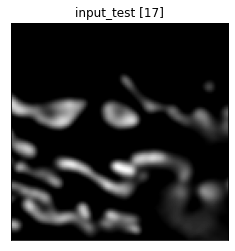

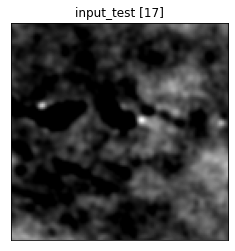

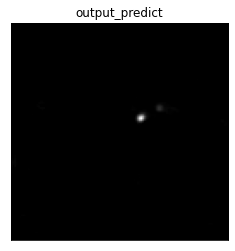

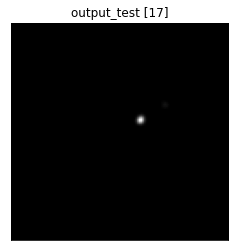

test_id :  18



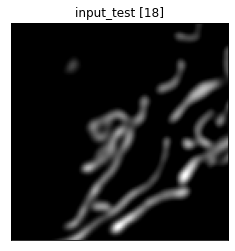

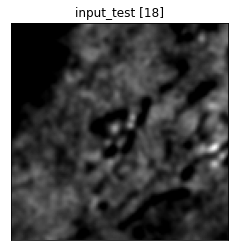

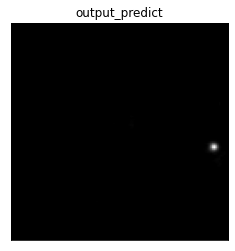

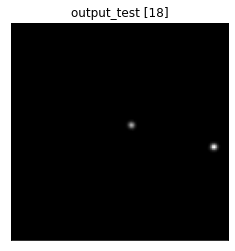

test_id :  19



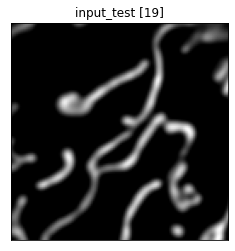

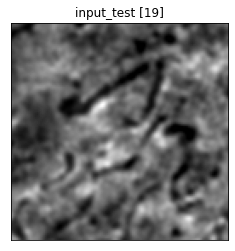

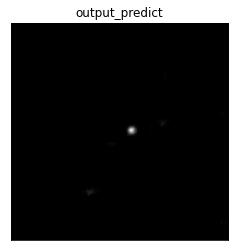

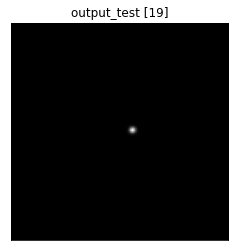

test_id :  20



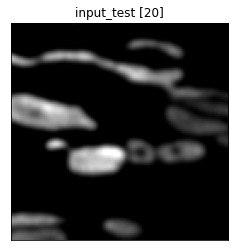

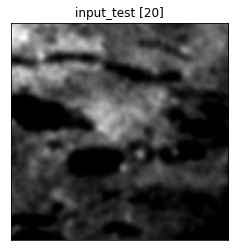

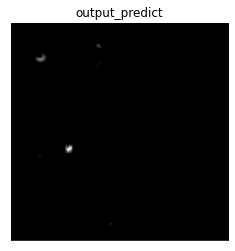

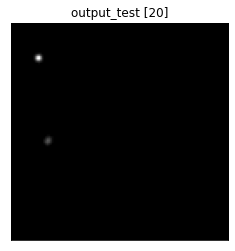

test_id :  21



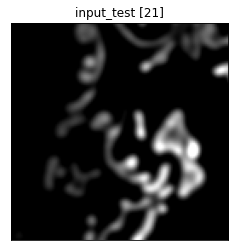

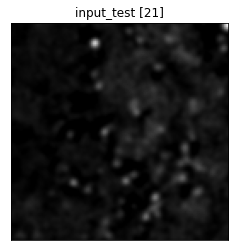

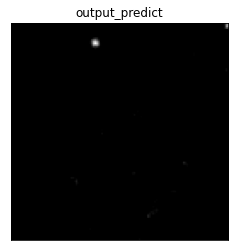

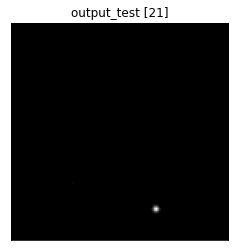

test_id :  22



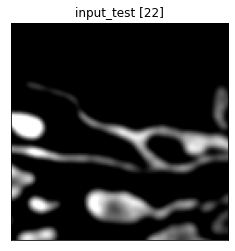

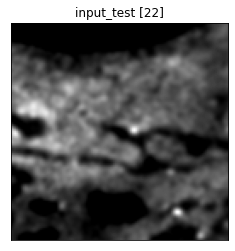

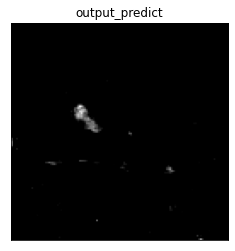

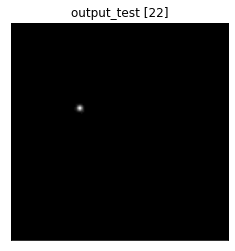

test_id :  23



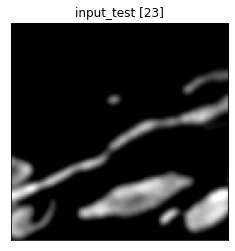

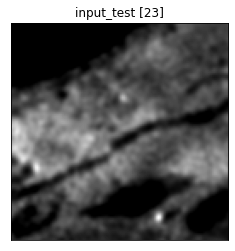

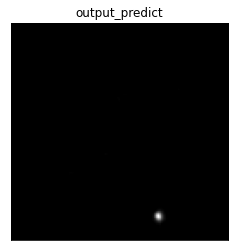

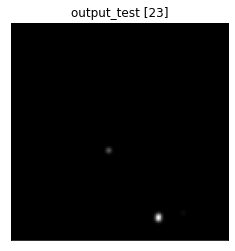

test_id :  24



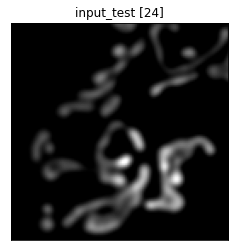

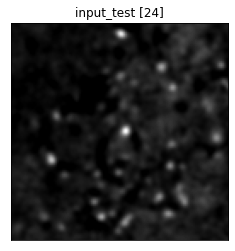

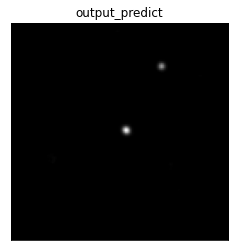

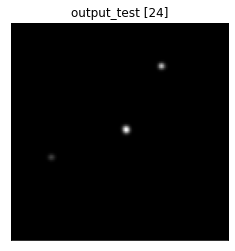

test_id :  25



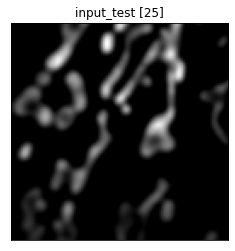

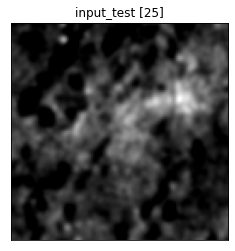

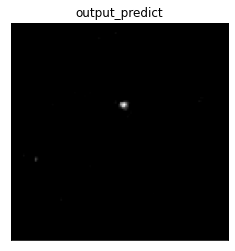

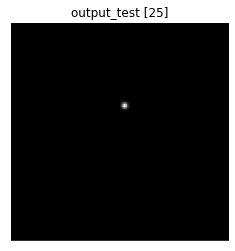

test_id :  26



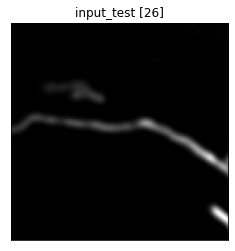

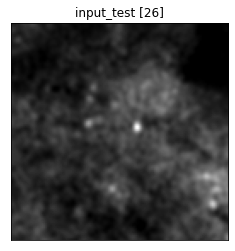

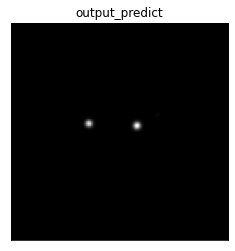

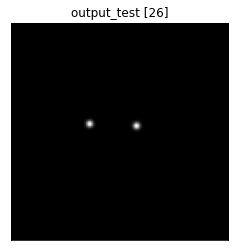

test_id :  27



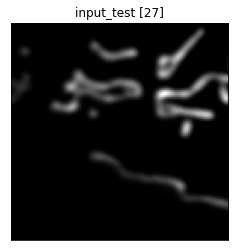

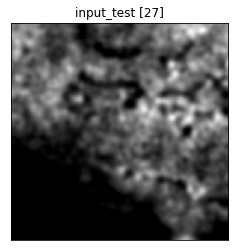

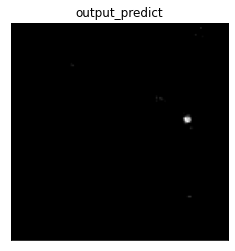

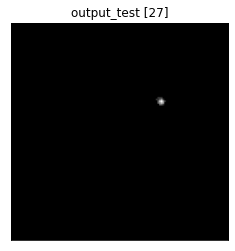

test_id :  28



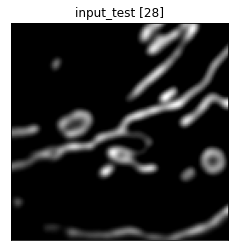

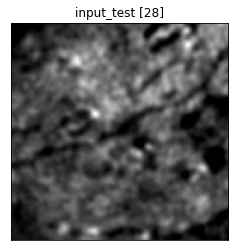

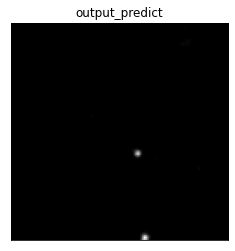

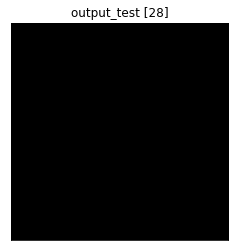

test_id :  29



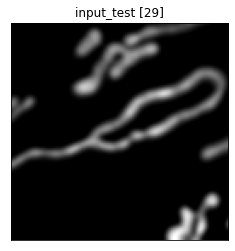

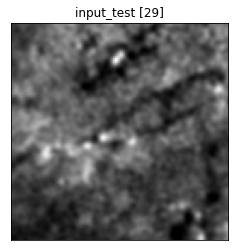

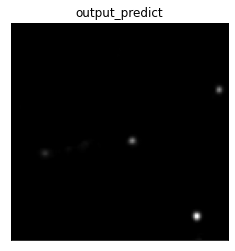

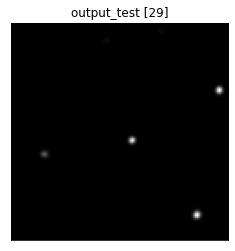

test_id :  30



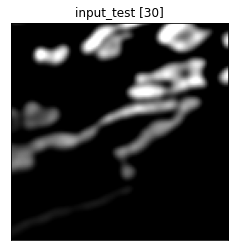

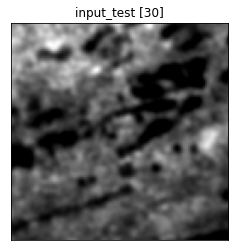

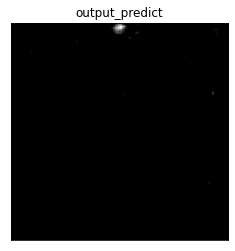

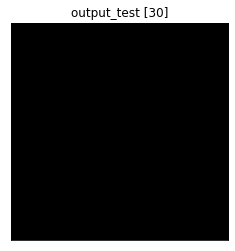

test_id :  31



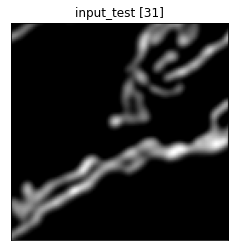

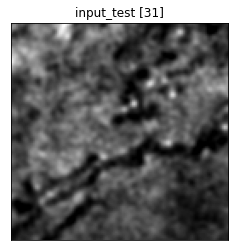

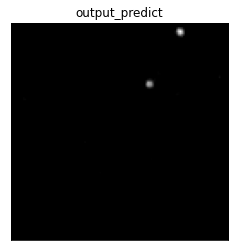

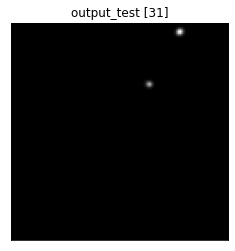

test_id :  32



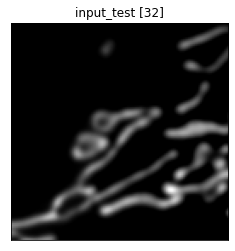

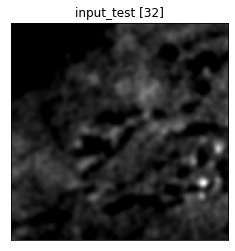

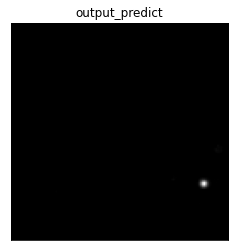

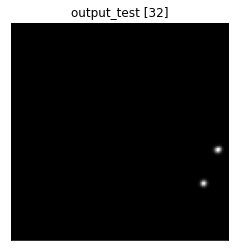

test_id :  33



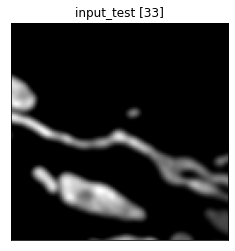

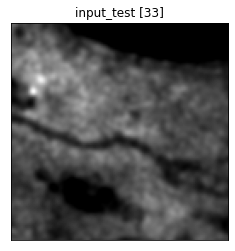

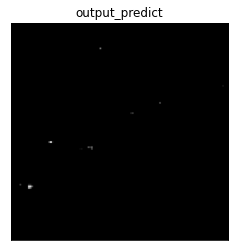

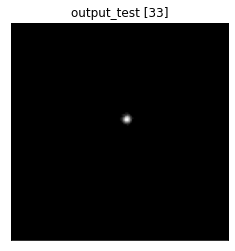

test_id :  34



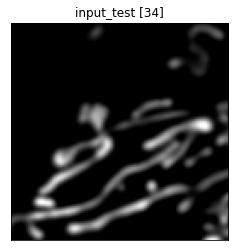

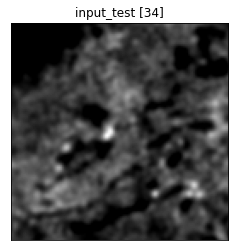

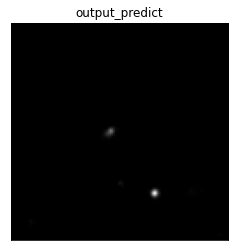

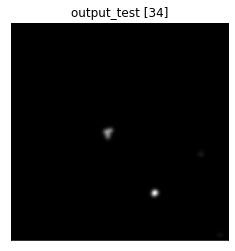

test_id :  35



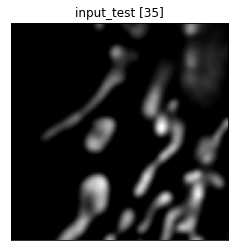

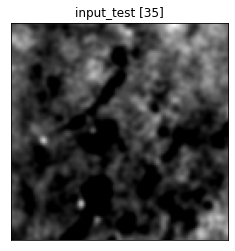

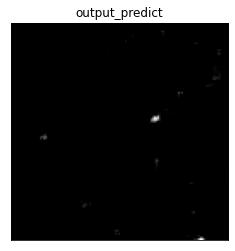

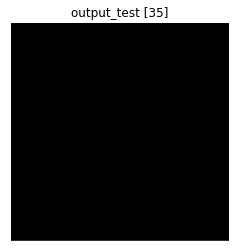

test_id :  36



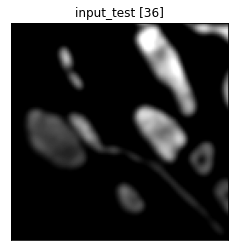

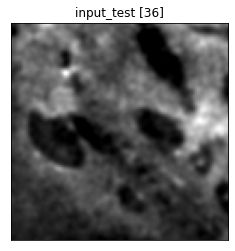

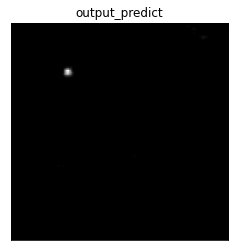

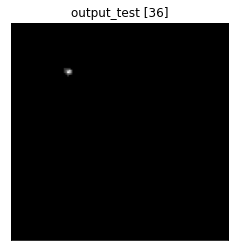

test_id :  37



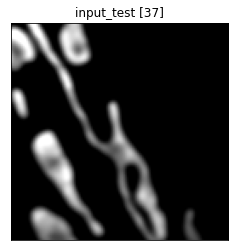

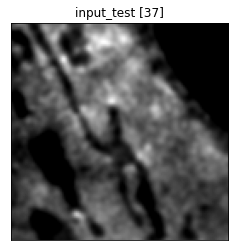

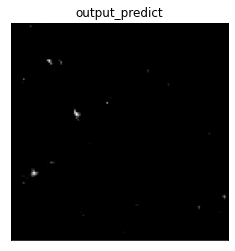

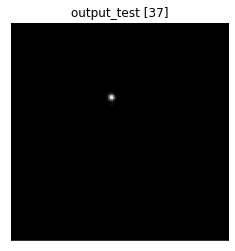

test_id :  38



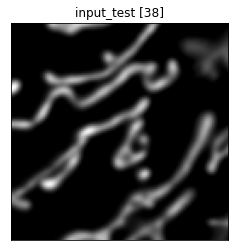

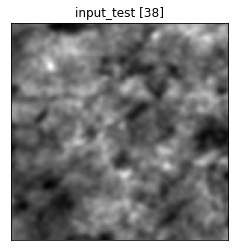

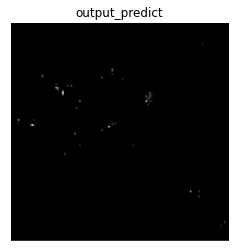

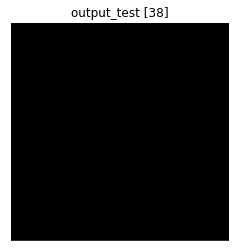

test_id :  39



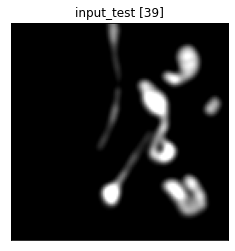

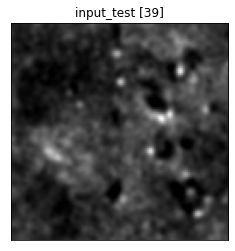

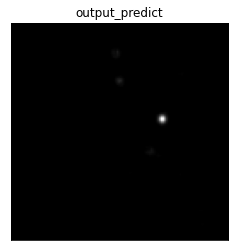

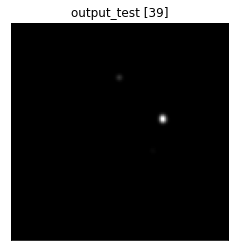

test_id :  40



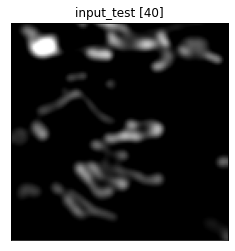

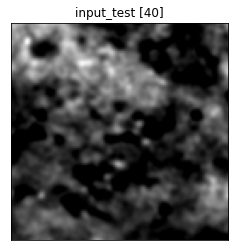

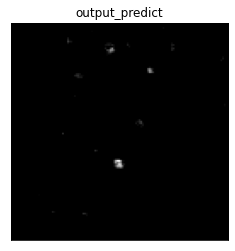

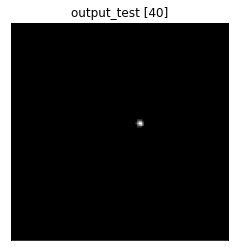

test_id :  41



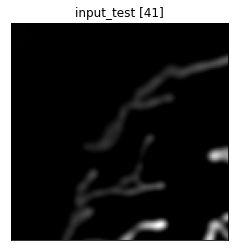

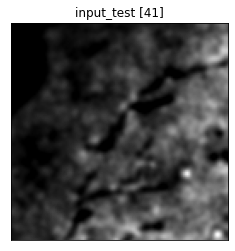

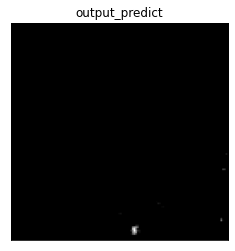

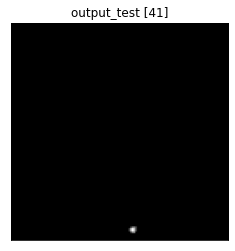

test_id :  42



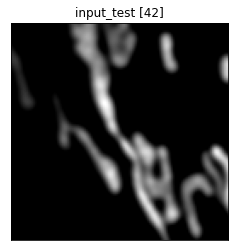

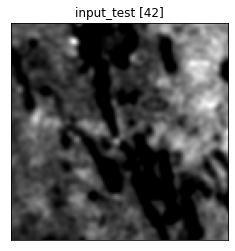

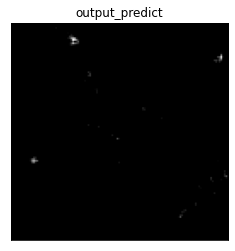

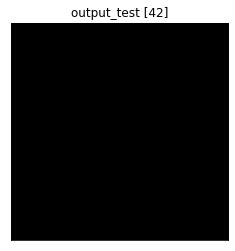

test_id :  43



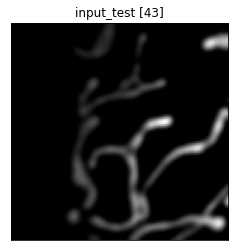

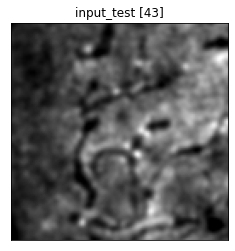

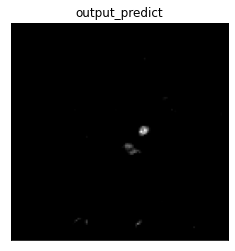

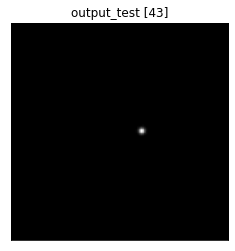

test_id :  44



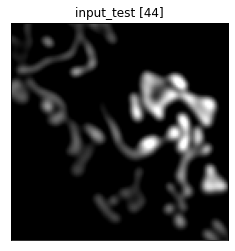

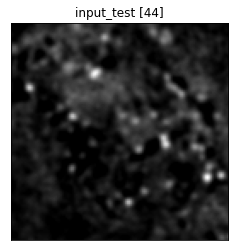

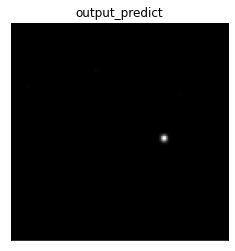

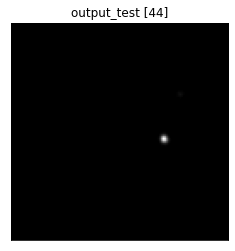

test_id :  45



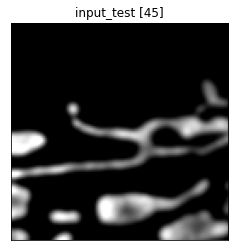

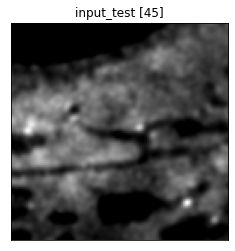

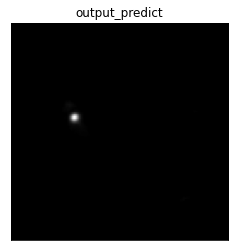

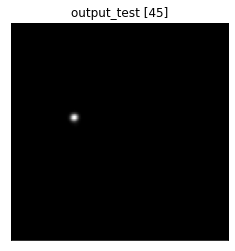

test_id :  46



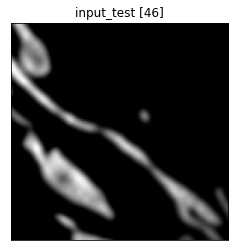

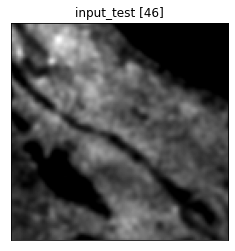

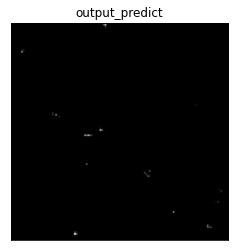

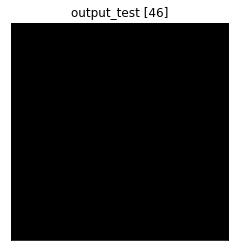

test_id :  47



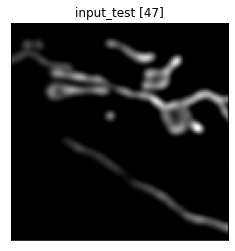

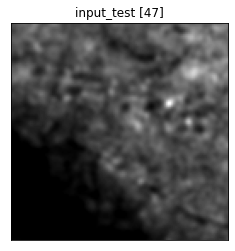

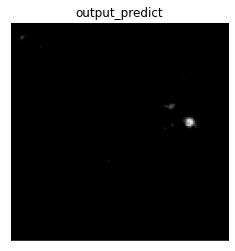

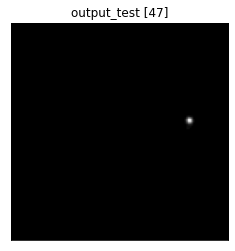

test_id :  48



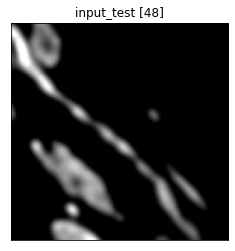

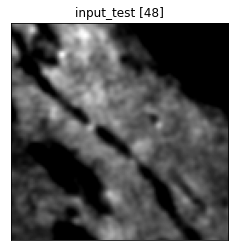

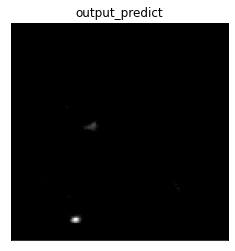

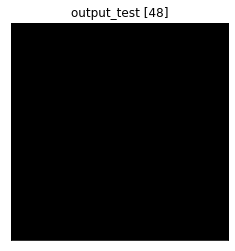

test_id :  49



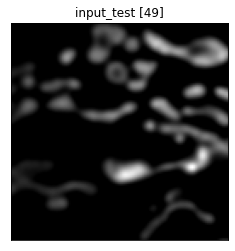

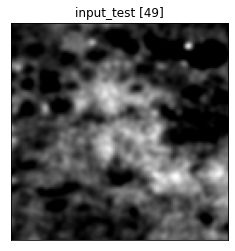

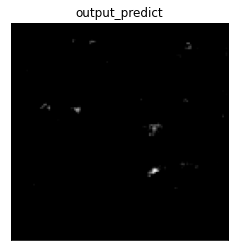

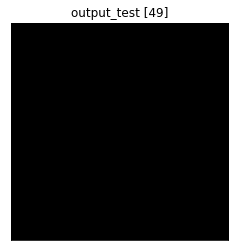

test_id :  50



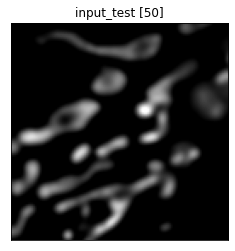

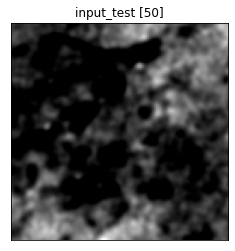

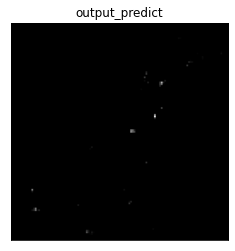

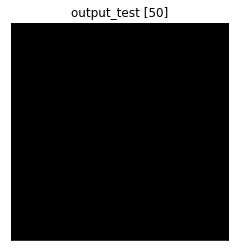

test_id :  51



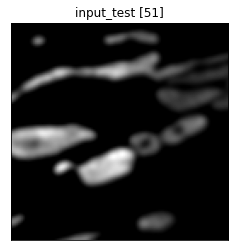

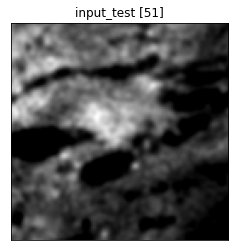

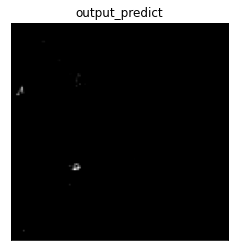

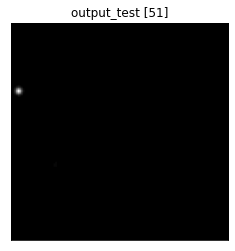

test_id :  52



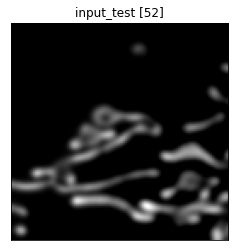

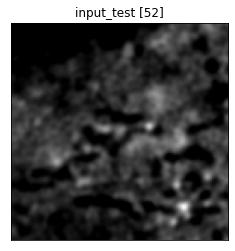

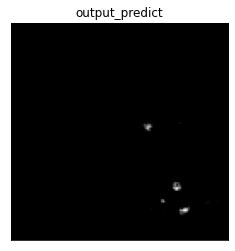

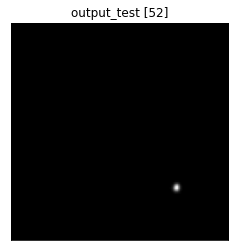

test_id :  53



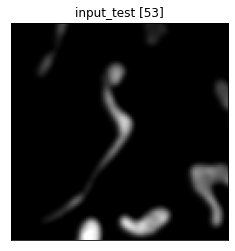

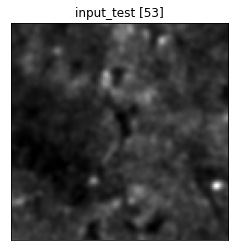

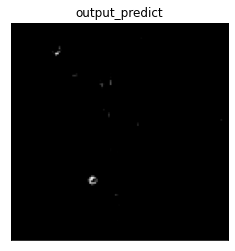

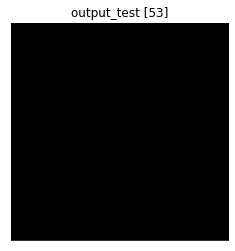

test_id :  54



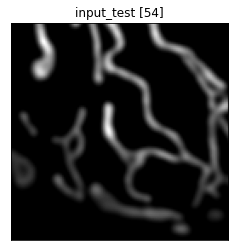

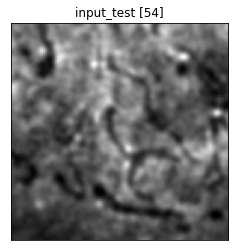

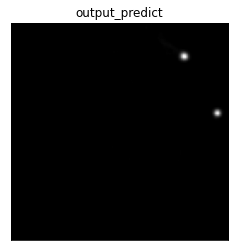

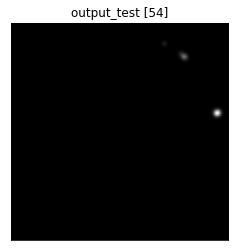

test_id :  55



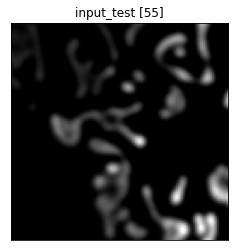

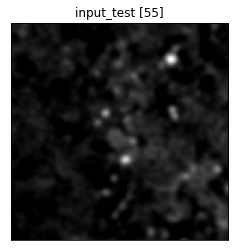

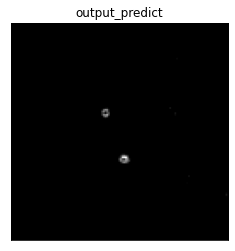

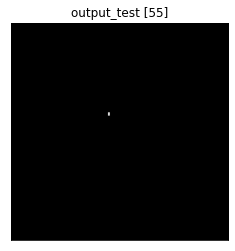

test_id :  56



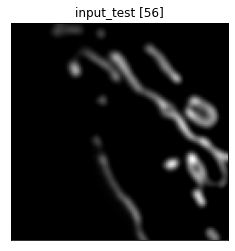

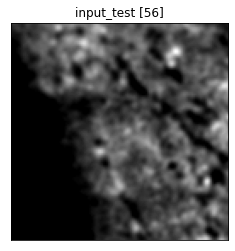

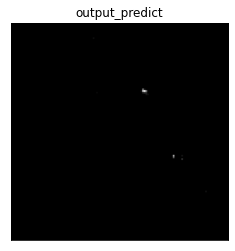

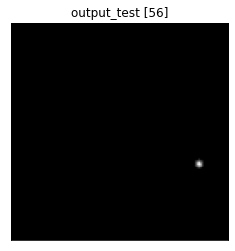

test_id :  57



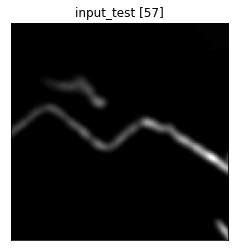

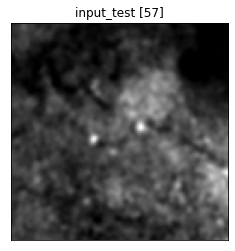

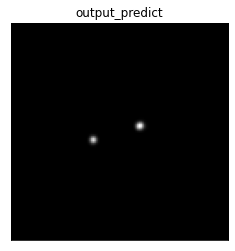

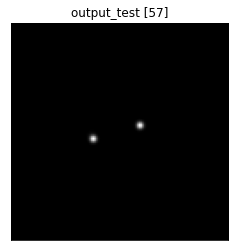

test_id :  58



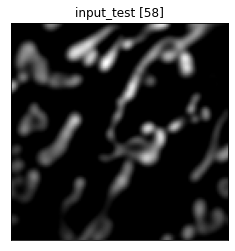

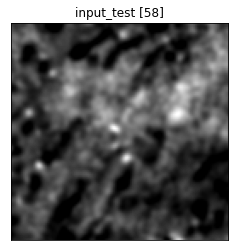

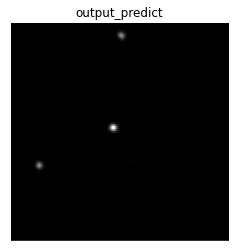

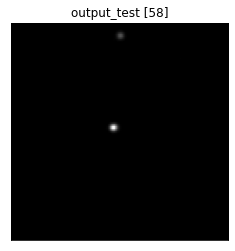

test_id :  59



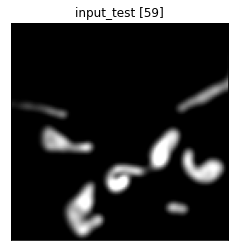

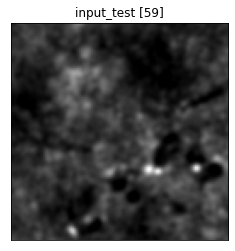

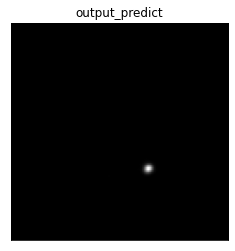

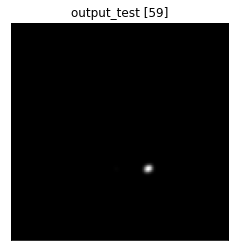

test_id :  60



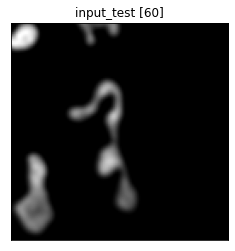

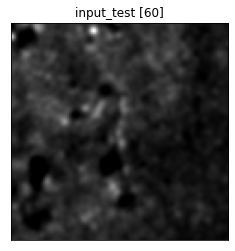

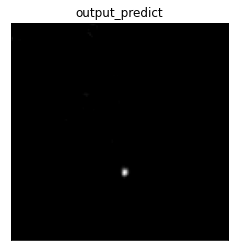

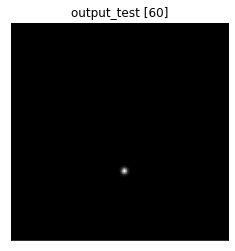

test_id :  61



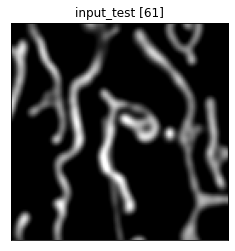

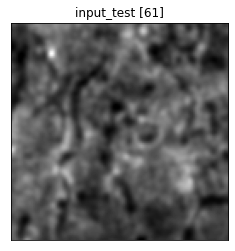

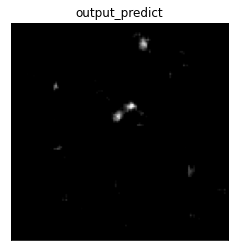

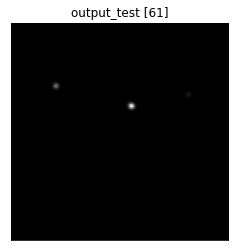

test_id :  62



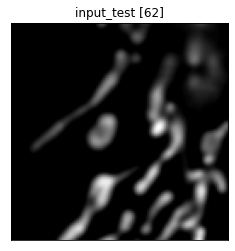

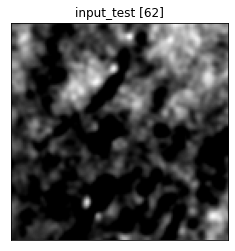

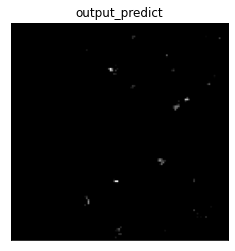

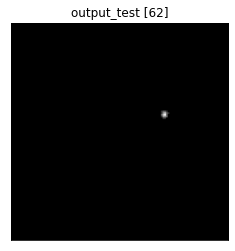

test_id :  63



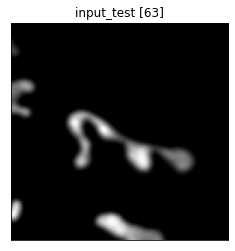

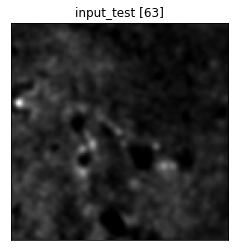

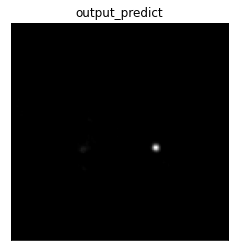

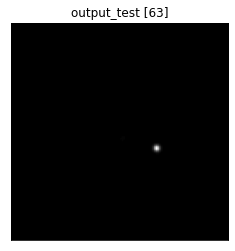

test_id :  64



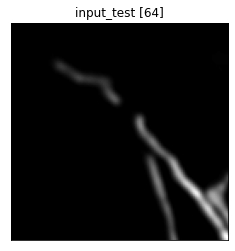

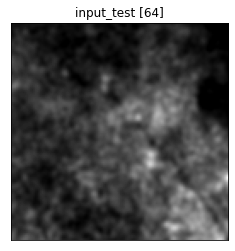

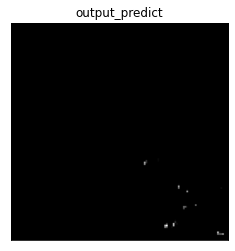

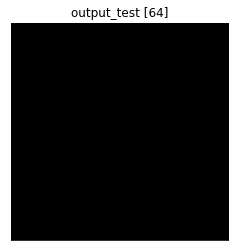

test_id :  65



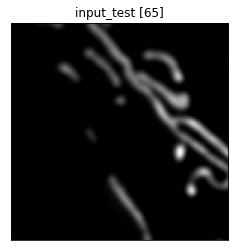

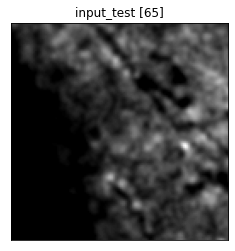

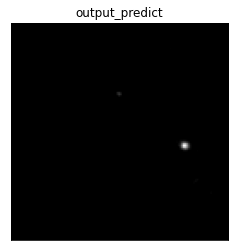

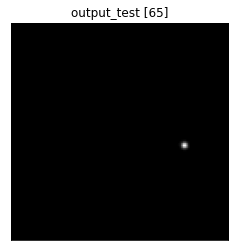

test_id :  66



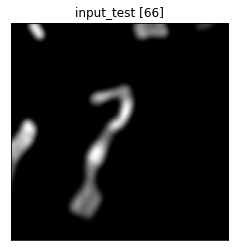

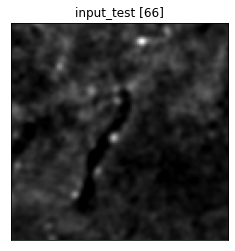

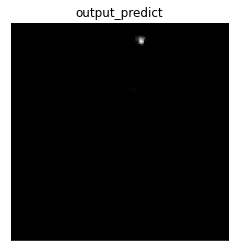

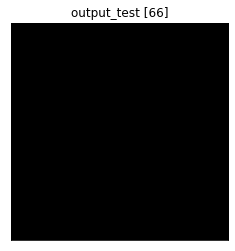

test_id :  67



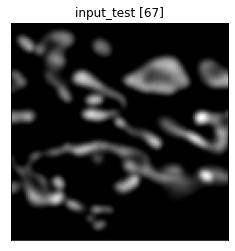

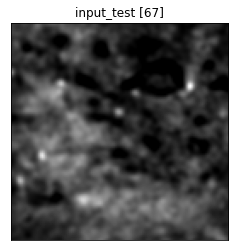

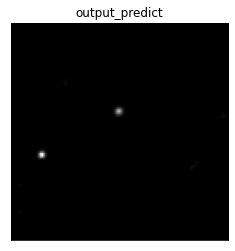

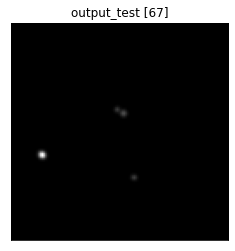

test_id :  68



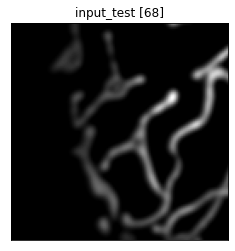

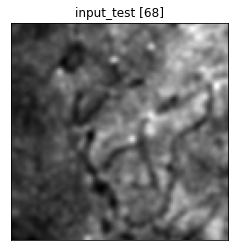

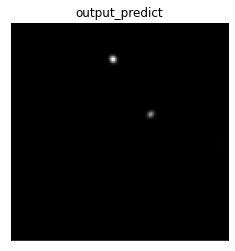

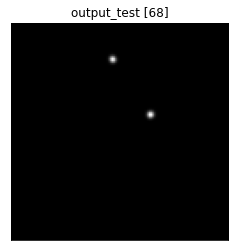

test_id :  69



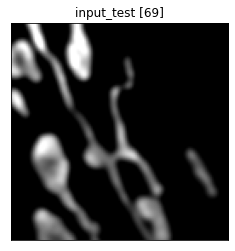

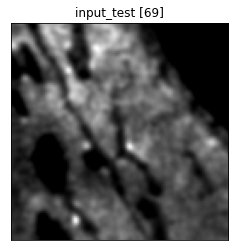

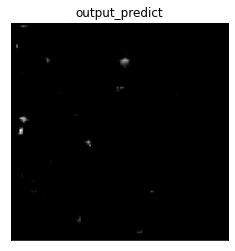

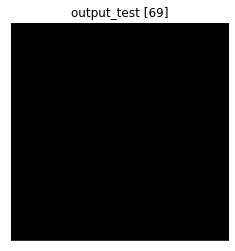

test_id :  70



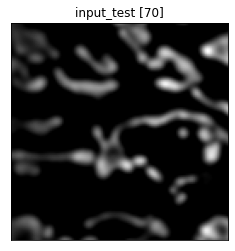

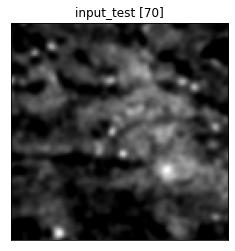

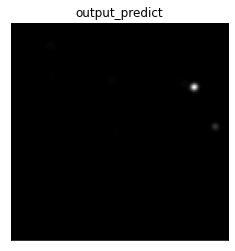

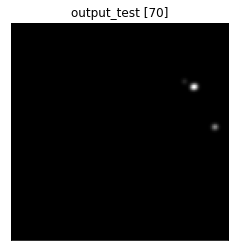

test_id :  71



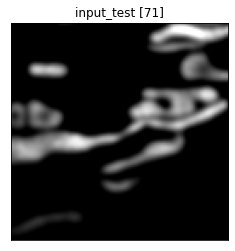

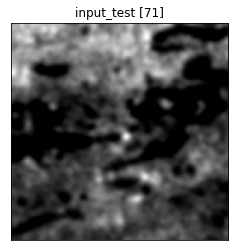

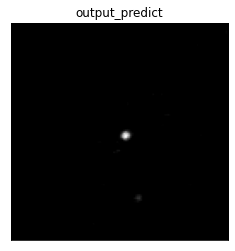

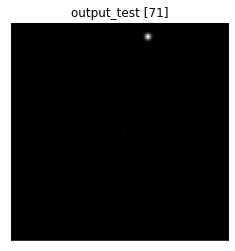

test_id :  72



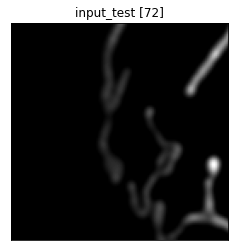

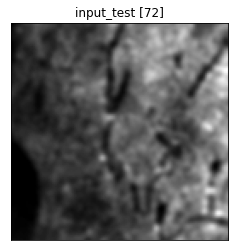

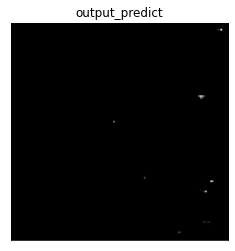

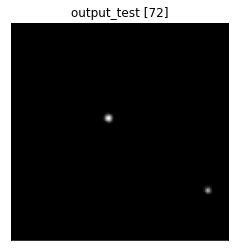

test_id :  73



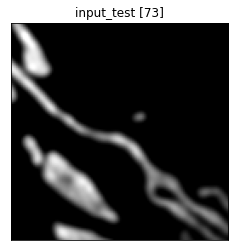

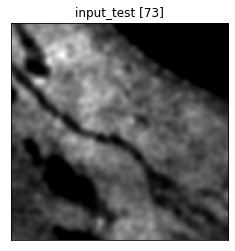

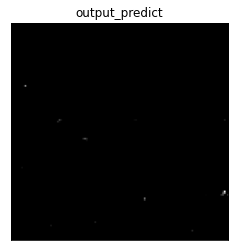

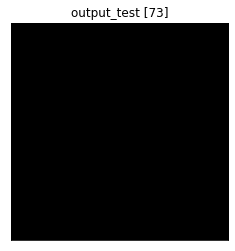

test_id :  74



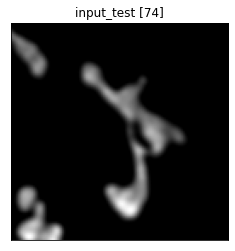

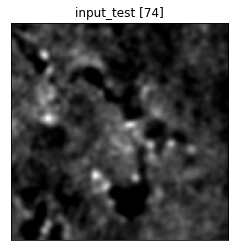

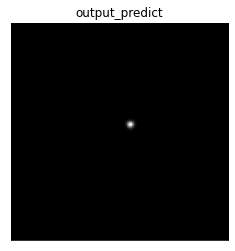

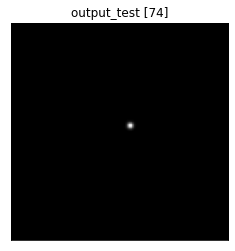

test_id :  75



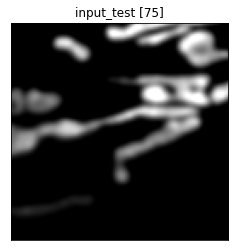

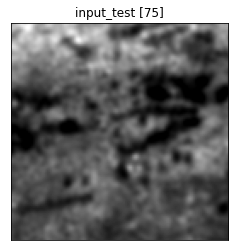

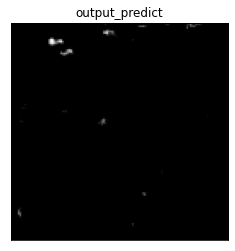

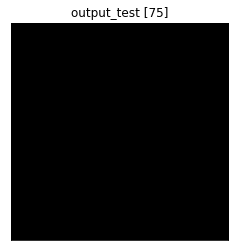

test_id :  76



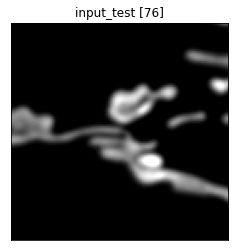

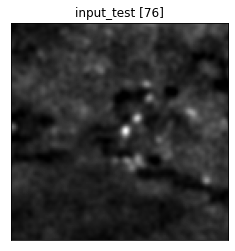

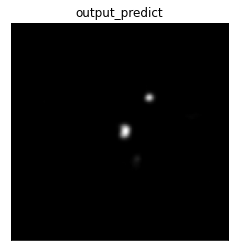

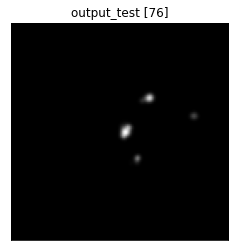

test_id :  77



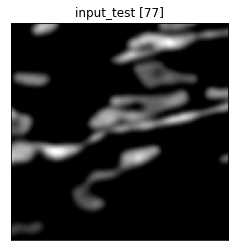

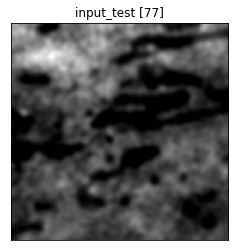

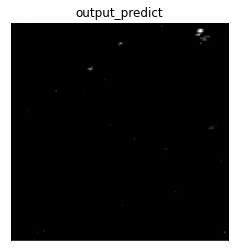

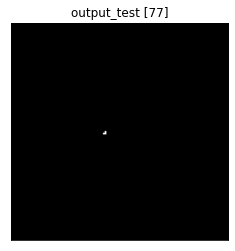

test_id :  78



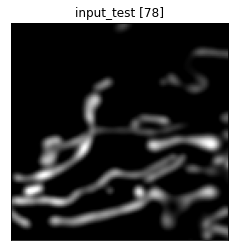

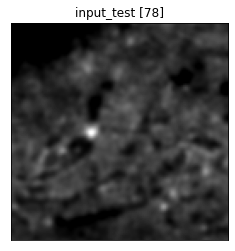

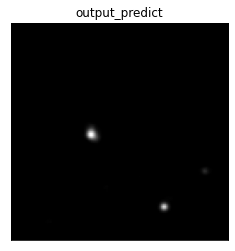

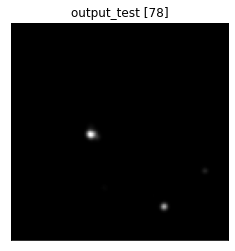

test_id :  79



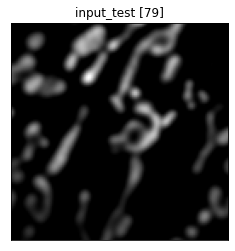

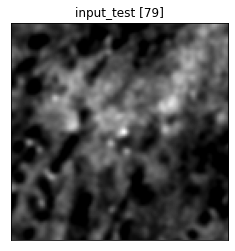

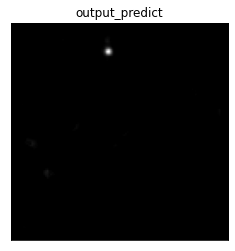

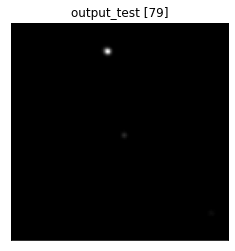

test_id :  80



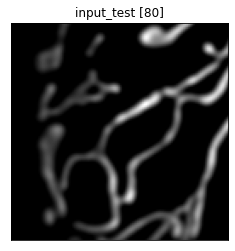

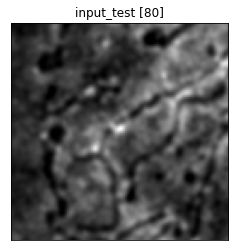

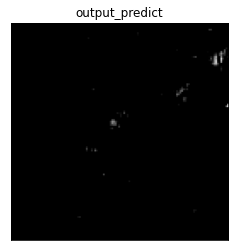

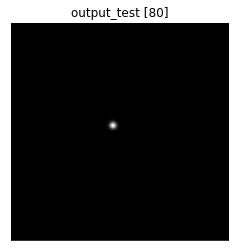

test_id :  81



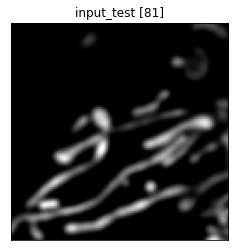

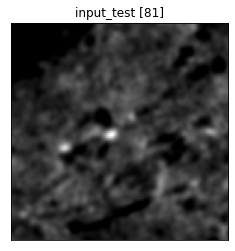

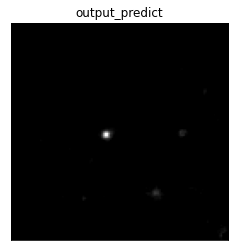

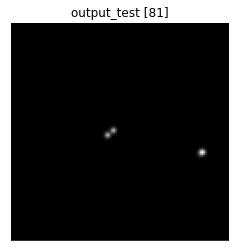

test_id :  82



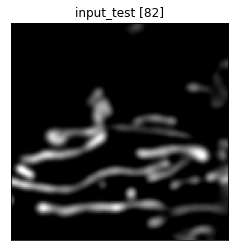

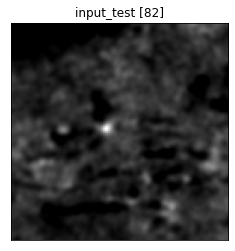

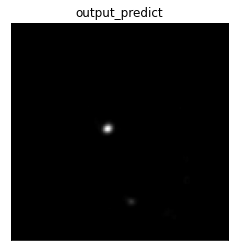

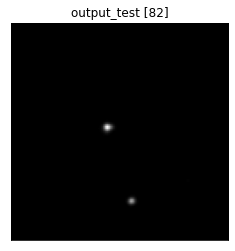

test_id :  83



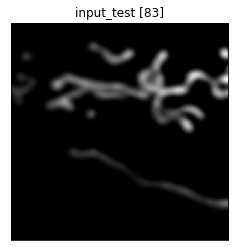

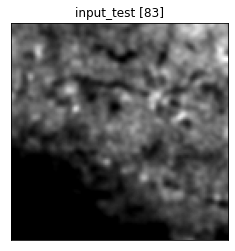

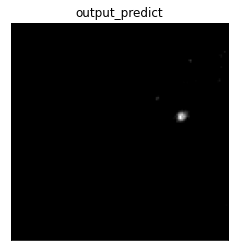

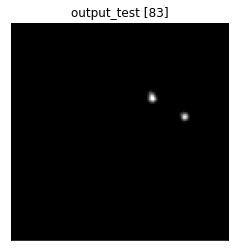

test_id :  84



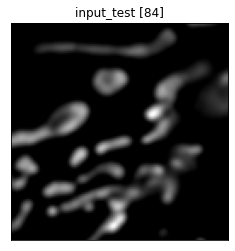

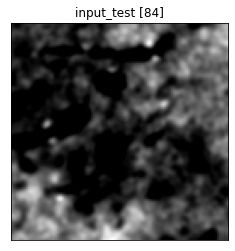

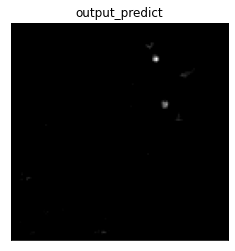

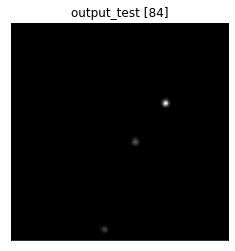

test_id :  85



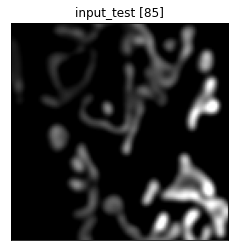

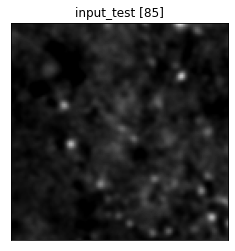

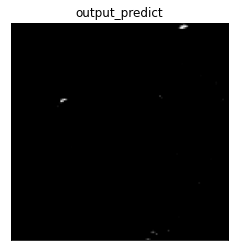

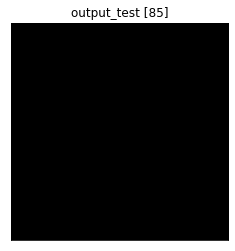

test_id :  86



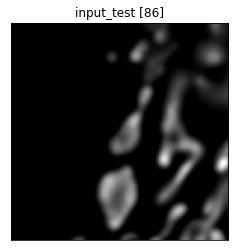

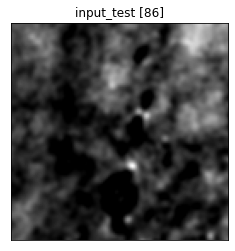

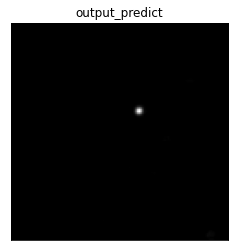

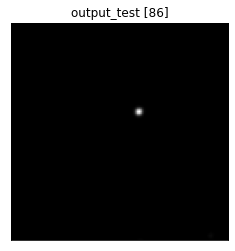

test_id :  87



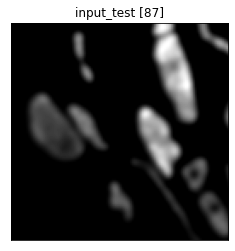

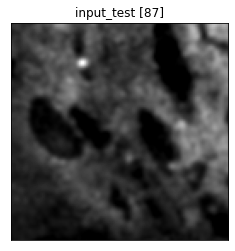

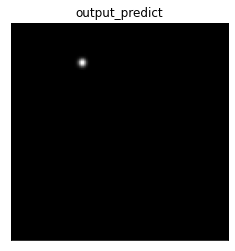

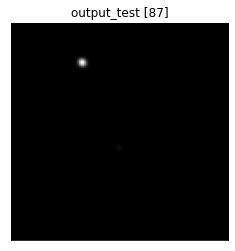

test_id :  88



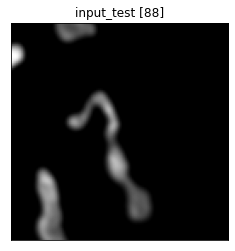

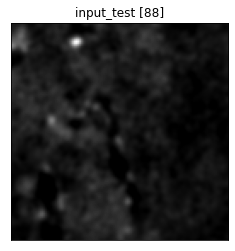

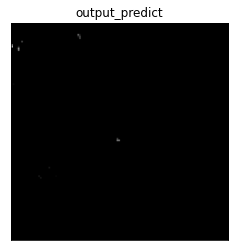

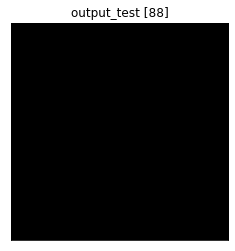

test_id :  89



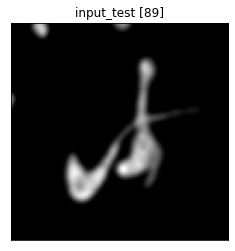

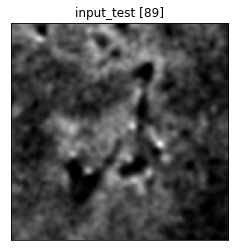

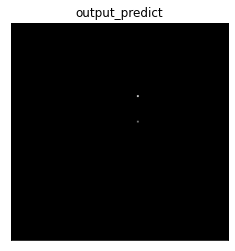

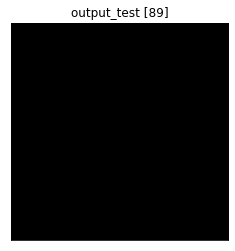

test_id :  90



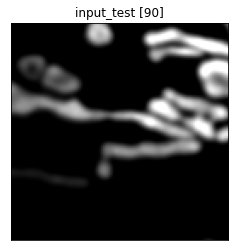

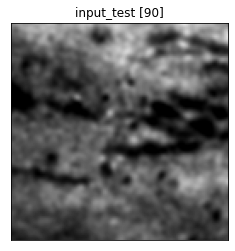

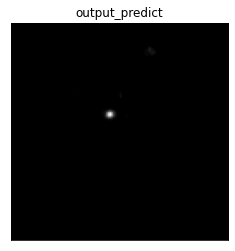

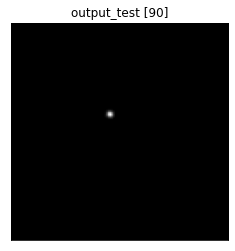

test_id :  91



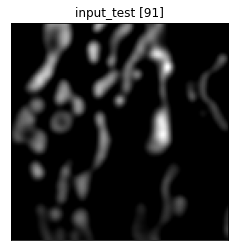

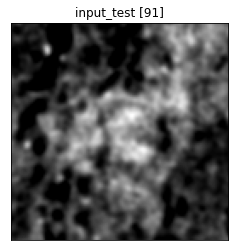

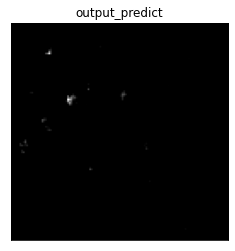

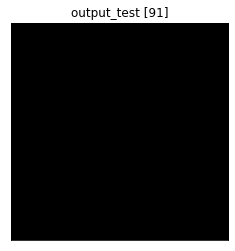

test_id :  92



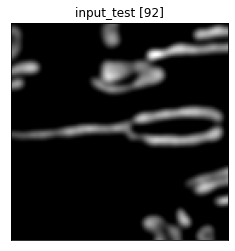

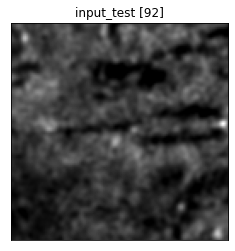

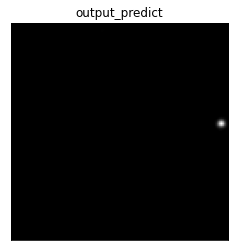

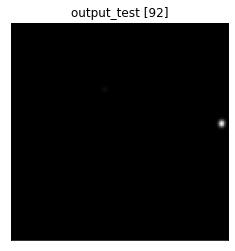

test_id :  93



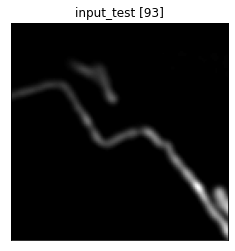

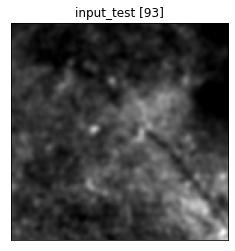

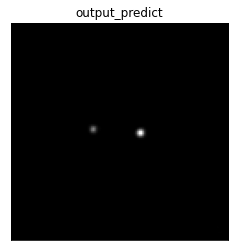

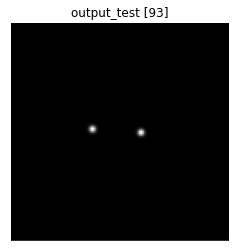

test_id :  94



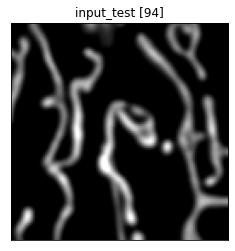

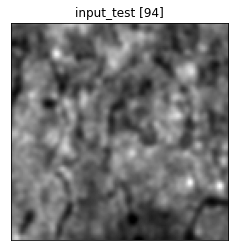

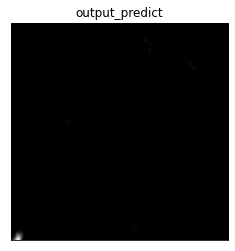

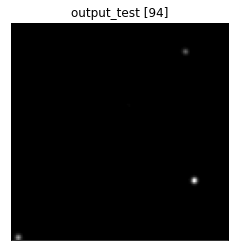

test_id :  95



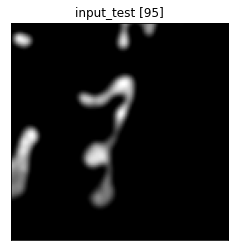

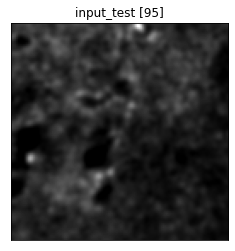

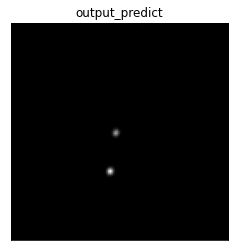

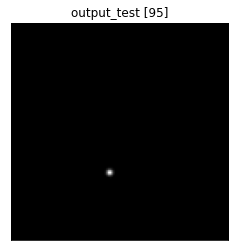

test_id :  96



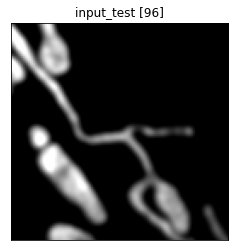

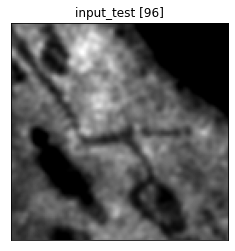

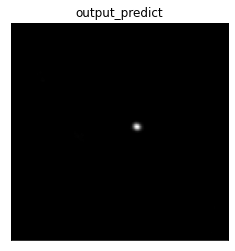

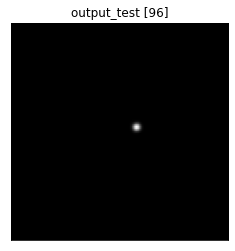

test_id :  97



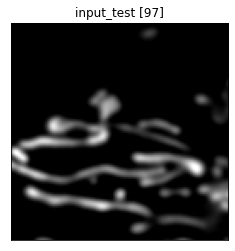

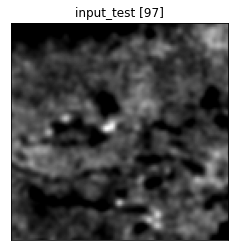

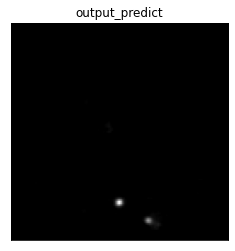

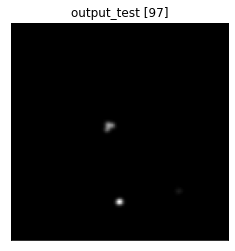

test_id :  98



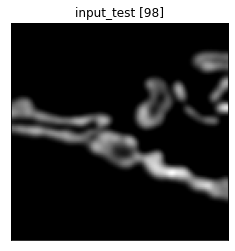

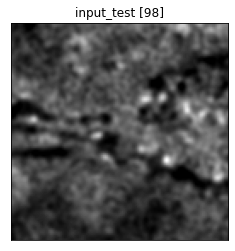

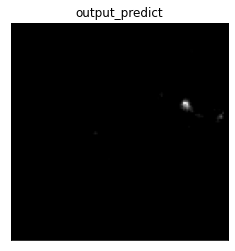

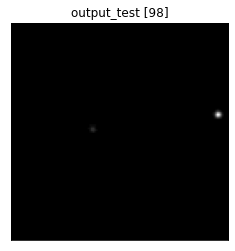

test_id :  99



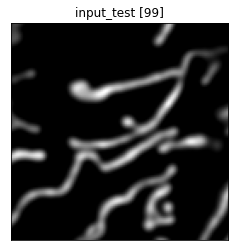

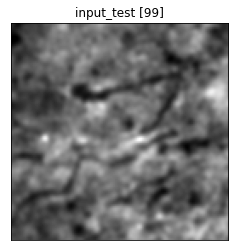

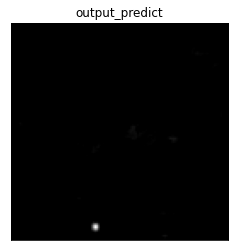

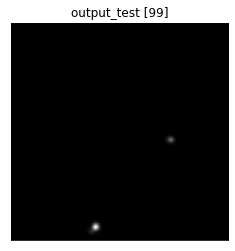

In [ ]:
print('* Predicting the output of a given input from test set *')
print()

#for i in range(input_test.shape[0]):
for i in range(100):
  test_id = i


  input_predict = np.zeros(shape=(1, 128, 128, 2, 1))  # create numpy array of required dimensions for network input

  input_predict[0, :, :, :, 0] = input_test[test_id, :, :, :, 0]  # reshaping test input image

  output_predict = model.predict(input_predict)


  print('test_id : ', test_id)
  print()

  # plot prediction example from test set

  plt.imshow(input_test[test_id, :, :, 0, 0], cmap='gray')
  plt.title('input_test [' + str(test_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  print()

  plt.imshow(input_test[test_id, :, :, 1, 0], cmap='gray')
  plt.title('input_test [' + str(test_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  print()

  plt.imshow(output_predict[0, :, :, 0], cmap='gray')
  plt.title('output_predict')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  print()

  plt.imshow(output_test[test_id, :, :, 0, 0], cmap='gray')
  plt.title('output_test [' + str(test_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()



In [ ]:

#Line of code

#Define network architecture functions

In [ ]:
def build_U_NET_4(lr=1e-3,kernel_size=(5,5), beta_1=0.9, beta_2=0.999, nb_filters=8, dropout=0.0, valid_train_split_ratio=0.2,input_shape=(128, 128, 2,1)):
  
  input_shape = (128, 128, 2,1)
  inputs = Input(shape=input_shape)

# encoder section

  down0 = Conv3D(nb_filters, (kernel_size[0], kernel_size[1], 2), padding='same')(inputs)
  down0 = BatchNormalization()(down0)
  down0 = Activation('relu')(down0)
  down0 = Conv3D(nb_filters, (kernel_size[0], kernel_size[1], 2), padding='same')(down0)
  down0 = BatchNormalization()(down0)
  down0 = Activation('relu')(down0)
  down0_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down0)
  down0_pool = Reshape((64, 64, nb_filters))(down0_pool)
  down0 = Reshape((128,128,nb_filters*2))(down0)
  

  
  conv3=Conv2D(filters=nb_filters*2,kernel_size=kernel_size,padding='same')(down0)
  conv3 = BatchNormalization()(conv3)
  conv3=Activation('relu')(conv3)
  conv4=Conv2D(filters=nb_filters*2,kernel_size=kernel_size,padding='same')(conv3)
  conv4 = BatchNormalization()(conv4)
  conv4=Activation('relu')(conv4)
  
  down2=MaxPooling2D(pool_size=(2,2))(conv4)
  
  conv5=Conv2D(filters=nb_filters*4,kernel_size=kernel_size,padding='same')(down2)
  conv5 = BatchNormalization()(conv5)
  conv5=Activation('relu')(conv5)
  conv6=Conv2D(filters=nb_filters*4,kernel_size=kernel_size,padding='same')(conv5)
  conv6 = BatchNormalization()(conv6)
  conv6=Activation('relu')(conv6)
  
  down3=MaxPooling2D(pool_size=(2,2))(conv6)
  
  conv7=Conv2D(filters=nb_filters*8,kernel_size=kernel_size,padding='same')(down3)
  conv7 = BatchNormalization()(conv7)
  conv7=Activation('relu')(conv7)
  conv8=Conv2D(filters=nb_filters*8,kernel_size=kernel_size,padding='same')(conv7)
  conv8 = BatchNormalization()(conv8)
  conv8=Activation('relu')(conv8)
  
  down4=MaxPooling2D(pool_size=(2,2))(conv8)
  
  #Center

  conv9=Conv2D(filters=nb_filters*16,kernel_size=kernel_size,padding='same')(down4)
  conv9 = BatchNormalization()(conv9)
  conv9=Activation('relu')(conv9)
  conv10=Conv2D(filters=nb_filters*16,kernel_size=kernel_size,padding='same')(conv9)
  conv10= BatchNormalization()(conv10)
  conv10=Activation('relu')(conv10)
  
  #Decoder
  
  up1=UpSampling2D(size=(2,2))(conv10)
  
  conv11=concatenate([up1,conv8],axis=3)
  conv11=Conv2D(filters=nb_filters*8,kernel_size=kernel_size,padding='same')(conv11)
  conv11 = BatchNormalization()(conv11)
  conv11=Activation('relu')(conv11)
  conv12=Conv2D(filters=nb_filters*8,kernel_size=kernel_size,padding='same')(conv11)
  conv12 = BatchNormalization()(conv12)
  conv12=Activation('relu')(conv12)
  
  up2=UpSampling2D(size=(2,2))(conv12)
  
  conv13=concatenate([up2,conv6],axis=3)
  conv13=Conv2D(filters=nb_filters*4,kernel_size=kernel_size,padding='same')(conv13)
  conv13 = BatchNormalization()(conv13)
  conv13=Activation('relu')(conv13)
  conv14=Conv2D(filters=nb_filters*4,kernel_size=kernel_size,padding='same')(conv13)
  conv14 = BatchNormalization()(conv14)
  conv14=Activation('relu')(conv14)
  
  up3=UpSampling2D(size=(2,2))(conv14)
 
  conv15=concatenate([up3,conv4],axis=3)
  conv15=Conv2D(filters=nb_filters*2,kernel_size=kernel_size,padding='same')(conv15)
  conv15 = BatchNormalization()(conv15)
  conv15=Activation('relu')(conv15)
  conv16=Conv2D(filters=nb_filters*2,kernel_size=kernel_size,padding='same')(conv15)
  conv16 = BatchNormalization()(conv16)
  conv16=Activation('relu')(conv16)
  
  up4=UpSampling2D(size=(2,2))(conv16)
  
  conv17=concatenate([up4,conv2],axis=3)
  conv17=Conv2D(filters=nb_filters,kernel_size=kernel_size,padding='same')(conv17)
  conv17 = BatchNormalization()(conv17)
  conv17=Activation('relu')(conv17)
  conv18=Conv2D(filters=nb_filters,kernel_size=kernel_size,padding='same')(conv17)
  conv18 = BatchNormalization()(conv18)
  conv18=Activation('relu')(conv18)
  
  outputs = Conv2D(1, (1, 1), activation='relu')(conv18)

  model=Model(inputs=inputs,outputs=outputs);
  model.compile(optimizer=Adam(lr=lr, beta_1=beta_1, beta_2=beta_2,  decay=0.0),loss='mean_squared_error',metrics=['mean_absolute_error'])
  return model

In [ ]:
def build_U_NET_2(lr=1e-3,kernel_size=5,nb_filters=8, beta_1=0.9, beta_2=0.999, dropout=0.0, valid_train_split_ratio=0.2,input_shape=(32,32,1)):
  

  #Encoder
  
  input_shape = (128, 128, 2,1)
  inputs = Input(shape=input_shape)

# encoder section

  down0 = Conv3D(nb_filters, (kernel_size, kernel_size, 2), padding='same')(inputs)
  down0 = BatchNormalization()(down0)
  down0 = Activation('relu')(down0)
  down0 = Conv3D(nb_filters, (kernel_size, kernel_size, 2), padding='same')(down0)
  down0 = BatchNormalization()(down0)
  down0 = Activation('relu')(down0)
  down0_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down0)
  down0_pool = Reshape((64, 64, nb_filters))(down0_pool)
  down0 = Reshape((128,128,nb_filters*2))(down0)
  
  
  conv3=Conv2D(filters=2*nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(down0_pool)
  conv3 = BatchNormalization()(conv3)
  conv3=Activation('relu')(conv3)
  conv4=Conv2D(filters=2*nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(conv3)
  conv4 = BatchNormalization()(conv4)
  conv4=Activation('relu')(conv4)
  
  down2=MaxPooling2D(pool_size=(2,2))(conv4)
  
  #Center
  
  conv5=Conv2D(filters=4*nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(down2)
  conv5 = BatchNormalization()(conv5)
  conv5=Activation('relu')(conv5)
  conv6=Conv2D(filters=4*nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(conv5)
  conv6 = BatchNormalization()(conv6)
  conv6=Activation('relu')(conv6)
  
  #Decoder
   
  up1=UpSampling2D(size=(2,2))(conv6)
  
  conv7=concatenate([up1,conv4],axis=3)
  conv7=Conv2D(filters=2*nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(conv7)
  conv7 = BatchNormalization()(conv7)
  conv7=Activation('relu')(conv7)
  conv8=Conv2D(filters=2*nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(conv7)
  conv8 = BatchNormalization()(conv8)
  conv8=Activation('relu')(conv8)
   
  up2=UpSampling2D(size=(2,2))(conv8)
  
  conv9=concatenate([up2,down0],axis=3)
  conv9=Conv2D(filters=nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(conv9)
  conv9 = BatchNormalization()(conv9)
  conv9=Activation('relu')(conv9)
  conv10=Conv2D(filters=nb_filters,kernel_size=(kernel_size,kernel_size),padding='same')(conv9)
  conv10 = BatchNormalization()(conv10)
  conv10=Activation('relu')(conv10)
  
  outputs = Conv2D(1, (1, 1), activation='relu')(conv10)

  model=Model(inputs=inputs,outputs=outputs);
  model.compile(optimizer=Adam(lr=lr, beta_1=beta_1, beta_2=beta_2,  decay=0.0),loss='mean_squared_error',metrics=['mean_absolute_error'])
  return model

### Kernel window size

In [ ]:
# Loop to improve the network by choosing the best value for the kernel size

n=10
accuracy=[]
loss=[]
val_accuracy=[]
val_loss=[]
test_accuracy=[]
test_loss=[]

kernel_values=[3,5,7,9,11];
for k in range(5):
  kernel_size=kernel_values[k];
  model = build_U_NET_2(kernel_size=kernel_size);
  model.summary();
  history2=model.fit(input_train,output_train,epochs=20,batch_size=512,validation_split=0.2,verbose=2,shuffle=True)
  model_evaluation=model.evaluate(test_in,test_out)#evaluates return a 2-element vectors, it's first 'case' containing the loss and the second one containing the accuracy
  #training accuracy
  temp=np.array(history2.history['acc']);
  temp_size=(temp.shape[0]);
  accuracy.append(np.mean(temp[temp_size-n:temp_size]));
  #training loss
  temp=np.array(history2.history['loss']);
  temp_size=(temp.shape[0]);
  loss.append(np.mean(temp[temp_size-n:temp_size]));
  #validation accuracy
  temp=np.array(history2.history['val_acc']);
  temp_size=(temp.shape[0]);
  val_accuracy.append(np.mean(temp[temp_size-n:temp_size]));
  #validation loss
  temp=np.array(history2.history['val_loss']);
  temp_size=(temp.shape[0]);
  val_loss.append(np.mean(temp[temp_size-n:temp_size]));
  #test accuracy and loss
  test_accuracy.append(model_evaluation[1])
  test_loss.append(model_evaluation[0])
  
  """
  axs[k,0].plot(history2.history['acc'])
  axs[k,0].plot(history2.history['val_acc'])
  if(k==0): axs[k,0].set_title("Accuracy  with lr=%1.5f" % lr)
  axs[k,0].legend(['Training', 'Validation'], loc='best')
  
  
  axs[k,1].plot(history2.history['loss'])
  axs[k,1].plot(history2.history['val_acc'])
  if(k==0): axs[k,1].set_title("Loss with lr=%1.5f" % lr)
  axs[k,1].legend(['Training', 'Validation'], loc='best')
  """
kernel_size=kernel_values;
network=4;
save=True;
param='kernel window size'
"""
#Plots of the loss and accuracy on the test set obtained by varying the value of one of the network parameters
compare_fig(accuracy,param=param,x=kernel_size,title='Accuracy of training data as function of the'+param,save=save,name='kerAcc'+str(network));
compare_fig(loss,param=param,x=kernel_size,title='Loss of training data as function of the'+param,save=save,name='kerLoss'+str(network));             
compare_fig(val_accuracy,param=param,x=kernel_size,title='Accuracy of validation data as function of the'+param,save=save,name='kerValAcc'+str(network)); 
compare_fig(val_loss,param=param,x=kernel_size,title='Loss of validation data as function of the'+param,save=save,name='kerValLoss'+str(network));
compare_fig(test_accuracy,param=param,x=kernel_size,title='Accuracy of test data as function of the'+param,save=save,name='kerTes_Acc'+str(network));  
compare_fig(test_loss,param=param,x=kernel_size,title='Loss of test data as function of the'+param,save=save,name='kerTes_Loss'+str(network));
"""
np.savetxt('kerAcc2.txt', (accuracy), fmt='%.18g', delimiter=' ')
np.savetxt('kerValAcc2.txt', (val_accuracy), fmt='%.18g', delimiter=' ')
np.savetxt('kerTes_Acc2.txt', (test_accuracy), fmt='%.18g', delimiter=' ')
np.savetxt('kerLoss2.txt', (loss), fmt='%.18g', delimiter=' ')
np.savetxt('kerValLoss2.txt', (val_loss), fmt='%.18g', delimiter=' ')
np.savetxt('kerTes_Loss2.txt', (test_loss), fmt='%.18g', delimiter=' ')

compare_fig_tvt(accuracy,val_accuracy,test_accuracy,x=kernel_size,title='Accuracy as function of the '+param,save=save,name='Acc'+str(network));
compare_fig_tvt(loss,val_loss,test_loss,x=kernel_size,title='Loss as function of the '+param,save=save,name='Loss'+str(network));
  

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 2, 0                                            
__________________________________________________________________________________________________
conv3d_8 (Conv3D)               (None, 128, 128, 2,  152         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 128, 128, 2,  32          conv3d_8[0][0]                   
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 128, 128, 2,  0           batch_normalization_28[0][0]     
_______________________________________________________________________________________

NameError: ignored